In [1]:
# ### Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import random

# ### Statistics
import scipy.stats as sc_stats

# ### Cluster ###
from sklearn import cluster

# ### Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ### Methods for classification
import sklearn.metrics as sk_metrics 

# ### Model selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

# ### Methods for regression
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ### Manifold methods
from sklearn.decomposition import PCA
import sklearn.manifold as sk_manifold

# ### For feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

warnings.filterwarnings('ignore')

import utils as ute

In [2]:
pvalue_th = 0.05
seed_th = 0

In [3]:
df = pd.read_csv('Data/ProcessedData.csv')

print( "Columns name", df.columns )

print("Number of columns", df.shape[1])
print("Number of patients", df.shape[0])
print( "Data frame shape", df.shape )

Columns name Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification', 'rbc_nan', 'rbc_normal',
       'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
       'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
       'ane_no', 'age_imp_median', 'bp_imp_median', 'sg_imp_median',
       'al_imp_median', 'su_imp_median', 'bgr_imp_median', 'bu_imp_median',
       'sc_imp_median', 'sod_imp_median', 'pot_imp_median', 'hemo_imp_median',
       'pcv_imp_median', 'wc_imp_median', 'rc_imp_median', 'target'],
      dtype='object')
Number of columns 55
Number of patients 400
Data frame shape (400, 55)


## Cluster

In [4]:
features_to_use = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

clt_nona_idx = df[features_to_use].dropna().index
df_clt = df[features_to_use].dropna().reset_index(drop=True)
print("Shape", df_clt.shape)

ps_target_col = (df.loc[clt_nona_idx, "classification"] == "ckd")*1
ps_target_col = ps_target_col.reset_index(drop=True)

Shape (201, 28)


In [7]:
counter, max_iter = 0, 1 * 10 ** 4
clt_result_list = []
while True:
    
    if counter % 50 == 0:
        print("Iteration", counter, "of", max_iter, end="\r")
    
    cluster_idx = random.randint(0, 1)
    num_clusters = random.randint(2, 8)
    
    cluster_model_name = [
        "kmeans", "agglomerative"
    ]
    
    cluster_model = [
        cluster.KMeans(n_clusters=num_clusters), 
        cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
    ]
    
    num_features = random.randint(2, len(features_to_use))
    feat_to_alg = random.choices(features_to_use, k=num_features)
    
    y_pred = cluster_model[cluster_idx].fit_predict(df_clt[feat_to_alg])
    
    nmis = sk_metrics.cluster.normalized_mutual_info_score(ps_target_col.values, y_pred)
    
    clt_result_list.append({
        "Iteration": counter,
        "Model": cluster_model_name[cluster_idx],
        "NumClusters": num_clusters,
        "Features": feat_to_alg,
        "NumFeatures": len(feat_to_alg),
        "MutualInfoScore": nmis,
    })
    
    if counter >= max_iter:
        break
    else:
        counter += 1
    

In [16]:
df_clt_result = pd.DataFrame(clt_result_list)
df_clt_result = df_clt_result.sort_values("MutualInfoScore", ascending=False).reset_index(drop=True)
df_clt_result.head(8)

,Iteration,Model,NumClusters,Features,NumFeatures,MutualInfoScore
0,4225,agglomerative,2,"[al, su, hemo, pe_no]",4,0.926675
1,7527,agglomerative,2,"[rbc_normal, hemo, hemo, pc_nan, pot, appet_na...",20,0.898968
2,6533,agglomerative,2,"[appet_nan, hemo, su, rc]",4,0.898968
3,487,agglomerative,2,"[hemo, ba_notpresent, su, hemo]",4,0.898968
4,6086,agglomerative,2,"[rbc_normal, sc, pcc_notpresent, cad_no, appet...",7,0.898968
5,6019,agglomerative,2,"[pc_nan, cad_no, sg, sod, hemo, pot, sg, pcc_n...",20,0.873721
6,5037,agglomerative,2,"[ba_notpresent, sg, rc, pcc_notpresent, pe_no,...",11,0.873721
7,2412,agglomerative,3,"[rc, dm_yes, dm_nan, pot, dm_yes, htn_yes, rbc...",23,0.856672


In [9]:
print("Best model", df_clt_result.loc[0, "Model"])
print("Number of clusters", df_clt_result.loc[0, "NumClusters"])
print("Best features", df_clt_result.loc[0, "Features"])
print("Mutual info score", np.round(df_clt_result.loc[0, "MutualInfoScore"], 4) )

Best model agglomerative
Number of clusters 2
Best features ['al', 'su', 'hemo', 'pe_no']
Mutual info score 0.9267


In [18]:
df_clt[df_clt_result.loc[0, "Features"]].head(5)

,al,su,hemo,pe_no
0,4.0,0.0,11.2,0
1,3.0,0.0,12.2,0
2,2.0,0.0,9.5,1
3,3.0,0.0,10.8,0
4,3.0,1.0,9.7,0


In [21]:
all_top_features = []
for feat in df_clt_result["Features"].iloc[:5].to_list():
    all_top_features += feat
all_top_features_arr = np.array(all_top_features)

In [27]:
top_features = {col: np.sum(all_top_features_arr==col) for col in set(all_top_features)}
top_features = {k: v for k, v in sorted(top_features.items(), key=lambda item: item[1], reverse=True)}
top_features

{'hemo': 9,
 'rbc_normal': 5,
 'su': 3,
 'appet_nan': 3,
 'rc': 3,
 'pcc_notpresent': 2,
 'ane_no': 2,
 'pe_no': 2,
 'sc': 2,
 'cad_no': 1,
 'rbc_nan': 1,
 'pot': 1,
 'ba_notpresent': 1,
 'pc_nan': 1,
 'htn_yes': 1,
 'dm_nan': 1,
 'al': 1}

## Manifold

In [10]:
df_man = df.copy()

In [11]:
columns_to_manifold = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

print("Number of columns", len(columns_to_manifold))

Number of columns 28


In [12]:
index_man_nona = df_man[columns_to_manifold].dropna().index
df_man_nona = df_man.loc[index_man_nona].reset_index(drop=True)

print("Shape of the data", df_man_nona.shape)

Shape of the data (201, 55)


In [13]:
pca = PCA(n_components=2, random_state=seed_th)
pca_array = pca.fit_transform(df_man_nona[columns_to_manifold])

df_man_pca = pd.DataFrame(pca_array)
df_man_pca["Target"] = df_man_nona["classification"]

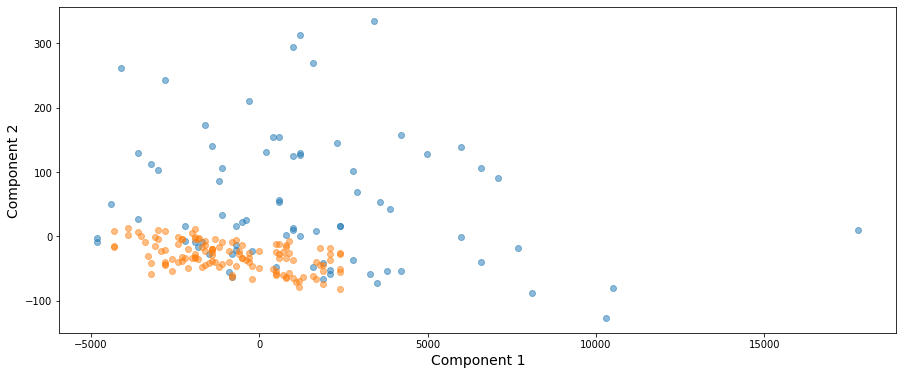

In [14]:
plt.figure(figsize=(15, 6))

for g, df_g in df_man_pca.groupby("Target"):

    plt.scatter(df_g[0], df_g[1], alpha=0.5)

plt.ylabel("Component 2", fontsize=14)
plt.xlabel("Component 1", fontsize=14)
    
plt.show()